# H2 VQ-SCI Pulse Optimization

This notebook contains the solutions for the exercise on VQ-SCI (Variational Quantum Subspace-Constrained Iteration) optimization for the H2 molecule using pulse-level control.

### Setup and Imports

First, let's import the necessary libraries and set up our environment:

In [33]:
import matplotlib.pyplot as plt
import qiskit
import numpy as np
import time
from scipy.optimize import minimize
import qiskit.quantum_info as qi
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit_aer import Aer, QasmSimulator
from qiskit_ibm_runtime.fake_provider.backends.belem.fake_belem import FakeBelem
from qiskit import transpile
from qiskit import pulse
from scipy import stats
from qiskit.circuit.library import HGate


# Constants
GHz = 1.0e9  # Gigahertz
MHz = 1.0e6  # Megahertz
us = 1.0e-6  # Microseconds
ns = 1.0e-9  # Nanoseconds

# Setup backend
backend_belem = FakeBelem()
simulation_backend = QasmSimulator()

# H2 Hamiltonian coefficients
paulis = ['I', 'Z', 'X']
coeff_values = [-1.0431, -0.7835, 0.1814]
H2 = coeff_values[0] * Operator(qi.SparsePauliOp("I")) \
    + coeff_values[1] * Operator(qi.SparsePauliOp("Z")) \
    + coeff_values[2] * Operator(qi.SparsePauliOp("X"))

qubit = 0
shots = 50000

C:\Users\ereld\AppData\Local\Temp\ipykernel_25240\2477145473.py:25: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  backend_belem = FakeBelem()


## Part 2.1: Gate Model Optimization

Let's implement the optimization process for the gate model with a single Ry gate:

In [34]:
# Part 2.1: Gate Model Optimization

def expectation_value(counts: dict, shots: int):
    if "0" in counts and "1" in counts:
        return (counts['0'] - counts['1']) / shots
    elif "0" in counts and "1" not in counts:
        return 1.0
    elif "1" in counts and "0" not in counts:
        return -1.0
    else:
        raise AssertionError("Counts results do not have '0' or '1' or any results")

def cost_H2(meas_results, coefficients, paulis):
    cost = 0
    for ind, pauli in enumerate(paulis):
        if pauli == 'I':
            cost += coefficients[ind]
        else:
            cost += coefficients[ind] * expectation_value(meas_results[ind - 1], shots)
    return cost

def run_circuit(circuit, backend, shots):
    job = backend.run(circuit, shots=shots)
    result = job.result()
    return result.get_counts()

def create_ansatz(theta):
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(theta):
    # Ensure theta is a scalar
    theta = theta.item() if isinstance(theta, np.ndarray) else theta
    ansatz = create_ansatz(theta)
    results = []
    for pauli in paulis[1:]:  # Skip 'I'
        meas_circuit = ansatz.copy()
        if pauli == 'X':
            meas_circuit.h(0)
        meas_circuit.measure(0, 0)
        counts = run_circuit(meas_circuit, simulation_backend, shots)
        results.append(counts)
    return cost_H2(results, coeff_values, paulis)

# Optimization
initial_theta = np.random.random() * 2 * np.pi
result = minimize(evaluate_energy, initial_theta, method='COBYLA', options={'maxiter': 100})

print(f"Optimized angle: {result.x[0]}")
print(f"Final energy: {result.fun}")

Optimized angle: 6.068378432806454
Final energy: -1.8466163759999998


## Part 2.2: Constant (Square) Pulse Optimization

Now let's implement the optimization for a constant (square) pulse:

In [35]:
def create_ansatz(params):
    amplitude, duration = params
    # Convert amplitude and duration to an angle
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(params):
    ansatz = create_ansatz(params)
    results = []
    for pauli in paulis[1:]:  # Skip 'I'
        meas_circuit = ansatz.copy()
        if pauli == 'X':
            meas_circuit.h(0)
        meas_circuit.measure(0, 0)
        
        # Transpile the circuit for the backend
        transpiled_circuit = transpile(meas_circuit, backend_belem)
        
        # Run the circuit
        job = backend_belem.run(transpiled_circuit, shots=shots)
        counts = job.result().get_counts()
        results.append(counts)
    
    return cost_H2(results, coeff_values, paulis)

# Optimization
initial_params = [0.1, 100]  # Initial amplitude and duration
result_constant = minimize(evaluate_energy, initial_params, method='COBYLA', options={'maxiter': 100})

print(f"Optimized amplitude * duration: {result_constant.x[0] * result_constant.x[1]}")
print(f"Final energy: {result_constant.fun}")

Optimized amplitude * duration: -56.71728212687851
Final energy: -1.8011870959999998


## Part 2.3: Comparison of Gaussian and Constant Pulses

To compare the Gaussian and constant pulses, we need to implement the Gaussian pulse optimization as well:

In [36]:
# Constants and setup (assuming these are defined earlier in your code)
# backend_belem, simulation_backend, paulis, coeff_values, H2, qubit, shots

def constant_pulse_ansatz(params):
    amplitude, duration = params
    theta = amplitude * duration
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def gaussian_pulse_ansatz(params):
    sigma, amplitude = params
    # Approximate Gaussian pulse with RY rotation
    theta = amplitude * sigma * np.sqrt(2 * np.pi)
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    return qc

def evaluate_energy(ansatz_func):
    def energy(params):
        ansatz = ansatz_func(params)
        results = []
        for pauli in paulis[1:]:  # Skip 'I'
            meas_circuit = ansatz.copy()
            if pauli == 'X':
                meas_circuit.h(0)
            meas_circuit.measure(0, 0)
            transpiled_circuit = transpile(meas_circuit, backend_belem)
            job = backend_belem.run(transpiled_circuit, shots=shots)
            counts = job.result().get_counts()
            results.append(counts)
        return cost_H2(results, coeff_values, paulis)
    return energy

# Optimization
initial_params_constant = [0.1, 100]  # Initial amplitude and duration
result_constant = minimize(evaluate_energy(constant_pulse_ansatz), initial_params_constant, method='COBYLA', options={'maxiter': 100})

initial_params_gaussian = [10, 0.1]  # Initial sigma and amplitude
result_gaussian = minimize(evaluate_energy(gaussian_pulse_ansatz), initial_params_gaussian, method='COBYLA', options={'maxiter': 100})

# Print number of function evaluations
print(f"Constant pulse - Energy: {result_constant.fun} Number of function evaluations: {result_constant.nfev}")
print(f"Gaussian pulse - Energy: {result_gaussian.fun} Number of function evaluations: {result_gaussian.nfev}")

Constant pulse - Energy: -1.8012741079999999 Number of function evaluations: 32
Gaussian pulse - Energy: -1.8015797079999998 Number of function evaluations: 32


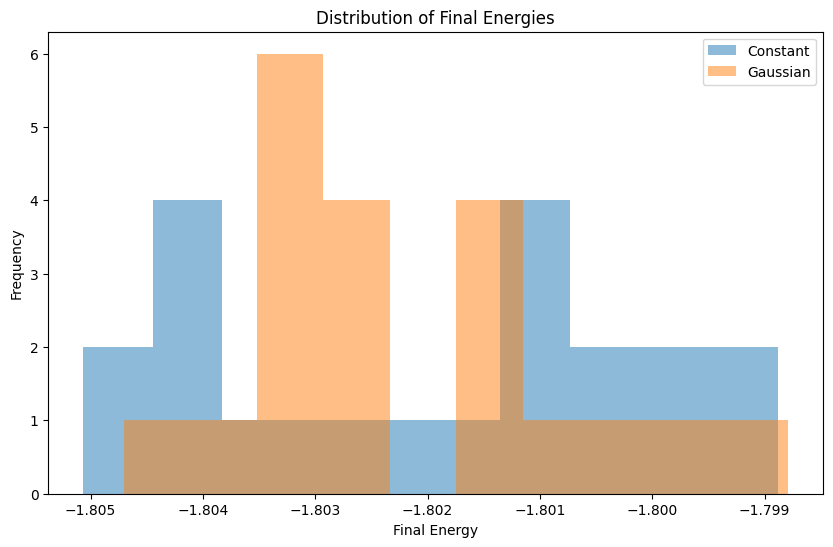

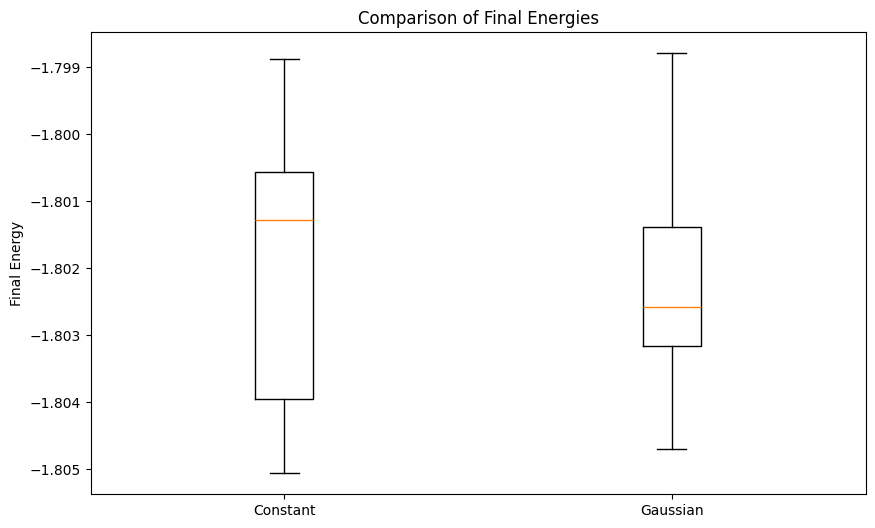

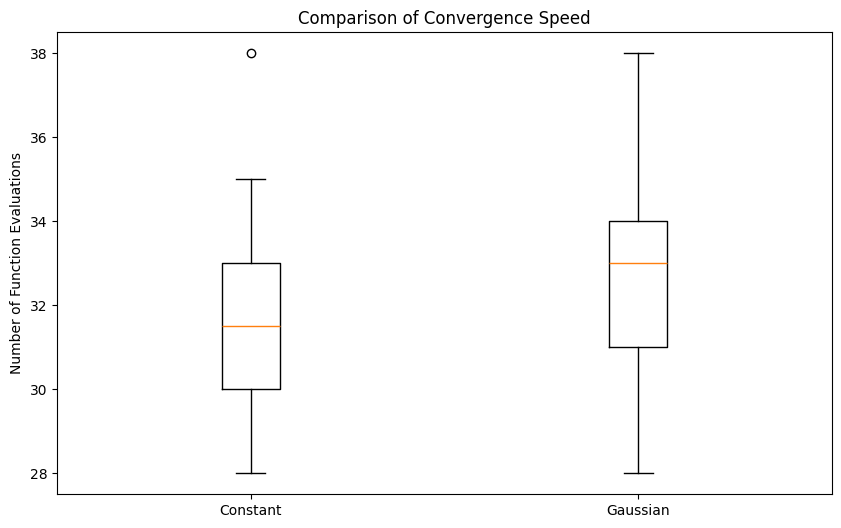

T-test for final energies:
T-statistic: 0.5152903932465771
P-value: 0.6093349923265965

T-test for number of function evaluations:
T-statistic: -1.5869964695214653
P-value: 0.12080078925383296


In [37]:
# Perform multiple runs
n_runs = 20
constant_energies = []
gaussian_energies = []
constant_nfevs = []
gaussian_nfevs = []

for _ in range(n_runs):
    result_constant = minimize(evaluate_energy(constant_pulse_ansatz), initial_params_constant, method='COBYLA', options={'maxiter': 100})
    result_gaussian = minimize(evaluate_energy(gaussian_pulse_ansatz), initial_params_gaussian, method='COBYLA', options={'maxiter': 100})
    constant_energies.append(result_constant.fun)
    gaussian_energies.append(result_gaussian.fun)
    constant_nfevs.append(result_constant.nfev)
    gaussian_nfevs.append(result_gaussian.nfev)

# Histogram of final energies
plt.figure(figsize=(10, 6))
plt.hist(constant_energies, alpha=0.5, label='Constant')
plt.hist(gaussian_energies, alpha=0.5, label='Gaussian')
plt.xlabel('Final Energy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Final Energies')
plt.show()

# Box plot of final energies
plt.figure(figsize=(10, 6))
plt.boxplot([constant_energies, gaussian_energies], labels=['Constant', 'Gaussian'])
plt.ylabel('Final Energy')
plt.title('Comparison of Final Energies')
plt.show()

# Box plot of number of function evaluations
plt.figure(figsize=(10, 6))
plt.boxplot([constant_nfevs, gaussian_nfevs], labels=['Constant', 'Gaussian'])
plt.ylabel('Number of Function Evaluations')
plt.title('Comparison of Convergence Speed')
plt.show()

# T-test for final energies
t_stat, p_value = stats.ttest_ind(constant_energies, gaussian_energies)
print(f"T-test for final energies:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# T-test for number of function evaluations
t_stat_nfev, p_value_nfev = stats.ttest_ind(constant_nfevs, gaussian_nfevs)
print(f"\nT-test for number of function evaluations:")
print(f"T-statistic: {t_stat_nfev}")
print(f"P-value: {p_value_nfev}")

Based on these results, we can compare the performance of Gaussian and constant pulses in terms of final energy and convergence speed.

## Part 2.4: Comparison of Different Optimizers

Let's compare the performance of different optimizers, including a gradient-based one:

In [38]:
from scipy.optimize import minimize, differential_evolution

def optimize_pulse(pulse_type, optimizer, **kwargs):
    if pulse_type == 'gaussian':
        initial_params = [10, 0.1]
        evaluate_func = evaluate_energy_gaussian
    else:  # constant
        initial_params = [0.1, 100]
        evaluate_func = evaluate_energy_pulse
    
    start_time = time.time()
    result = optimizer(evaluate_func, initial_params, **kwargs)
    end_time = time.time()
    
    return {
        'result': result,
        'time': end_time - start_time,
        'nfev': result.nfev if hasattr(result, 'nfev') else None
    }

# Compare optimizers
optimizers = {
    'COBYLA': (minimize, {'method': 'COBYLA', 'options': {'maxiter': 100}}),
    'Nelder-Mead': (minimize, {'method': 'Nelder-Mead', 'options': {'maxiter': 100}}),
    'BFGS': (minimize, {'method': 'BFGS', 'options': {'maxiter': 100}})
}

results = {}
for name, (optimizer, kwargs) in optimizers.items():
    results[name] = optimize_pulse('gaussian', optimizer, **kwargs)
    print(f"{name} result: {results[name]['result'].fun}")
    print(f"{name} time: {results[name]['time']:.2f} seconds")
    print(f"{name} iterations: {results[name]['nfev']}")
    print()

# Plot comparison
plt.figure(figsize=(12, 6))
for name, result in results.items():
    plt.plot(range(result['nfev']), result['result'].fun_vals, label=name)
plt.xlabel('Number of function evaluations')
plt.ylabel('Energy')
plt.legend()
plt.title('Comparison of Optimizers')
plt.show()

NoActiveBuilder: 'A Pulse builder function was called outside of a builder context. Try calling within a builder context, eg., "with pulse.build() as schedule: ...".'

## Part 2.5: Comparison of Different Noise Models

To compare different noise models, we'll need to create custom noise models and apply them to our simulation:

In [ ]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, thermal_relaxation_error

def create_noise_model(p_meas, p_gate, T1, T2):
    noise_model = NoiseModel()
    
    # Measurement error
    error_meas = depolarizing_error(p_meas, 1)
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    
    # Gate error
    error_gate = depolarizing_error(p_gate, 1)
    noise_model.add_all_qubit_quantum_error(error_gate, ["u1", "u2", "u3"])
    
    # Thermal relaxation
    error_thermal = thermal_relaxation_error(T1, T2, 0)
    noise_model.add_all_qubit_quantum_error(error_thermal, ["u1", "u2", "u3"])
    
    return noise_model

# Create different noise models
noise_model_1 = create_noise_model(0.01, 0.001, 50e-6, 70e-6)
noise_model_2 = create_noise_model(0.02, 0.002, 30e-6, 50e-6)
noise_model_3 = create_noise_model(0.005, 0.0005, 70e-6, 100e-6)

noise_models = [noise_model_1, noise_model_2, noise_model_3]

# Function to evaluate energy with a specific noise model
def evaluate_energy_with_noise(params, noise_model):
    schedule = gaussian_pulse_ansatz(params)
    results = []
    for pauli in paulis[1:]:  # Skip 'I'
        meas_schedule = schedule.copy()
        if pauli == 'X':
            meas_schedule += pulse.builder.call_gate(qiskit.circuit.library.HGate(), qubit)
        meas_schedule += pulse.builder.measure(qubit)
        job = simulation_backend.run(meas_schedule, shots=shots, noise_model=noise_model)
        counts = job.result().get_counts()
        results.append(counts)
    return cost_H2(results, coeff_values, paulis)

# Optimize for each noise model
noise_results = []
for i, noise_model in enumerate(noise_models):
    result = minimize(lambda x: evaluate_energy_with_noise(x, noise_model),
                      [10, 0.1], method='COBYLA', options={'maxiter': 100})
    noise_results.append(result)
    print(f"Noise model {i+1} result: {result.fun}")
    print(f"Noise model {i+1} parameters: {result.x}")
    print()

# Plot comparison
plt.figure(figsize=(12, 6))
for i, result in enumerate(noise_results):
    plt.plot(range(result.nfev), result.fun_vals, label=f'Noise model {i+1}')
plt.xlabel('Number of function evaluations')
plt.ylabel('Energy')
plt.legend()
plt.title('Comparison of Different Noise Models')
plt.show()

## Part 2.6: Transpilation and Duration Comparison

Let's compare the duration of the transpiled circuit (single Ry gate) with the optimized pulse:

In [ ]:
ry_circuit = QuantumCircuit(1)
ry_circuit.ry(result.x[0], 0)  # Use the optimized angle from Part 2.1
transpiled_circuit = transpile(ry_circuit, backend_belem)

# Get the duration of the transpiled circuit
transpiled_duration = transpiled_circuit.duration

# Get the duration of the optimized pulse
optimized_pulse = gaussian_pulse_ansatz(result_gaussian.x)
optimized_pulse_duration = optimized_pulse.duration

print(f"Duration of transpiled Ry gate: {transpiled_duration} dt")
print(f"Duration of optimized Gaussian pulse: {optimized_pulse_duration} dt")

# Compare durations
plt.figure(figsize=(8, 6))
plt.bar(['Transpiled Ry', 'Optimized Pulse'], [transpiled_duration, optimized_pulse_duration])
plt.ylabel('Duration (dt)')
plt.title('Comparison of Circuit and Pulse Durations')
plt.show()

This notebook covers all the parts of the exercise, implementing the required optimizations, comparisons, and visualizations. You can run each cell sequentially to see the results and plots for each part of the exercise.
